# FINAL NPZD PROTOTYPE

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV
from phydra.components.fluxes import (LinearForcingInput, LinearMortalityExchange,
                                      QuadraticMortality,
                                      ExponentialGrowth, MonodGrowth,
                                      HollingTypeIII, Old_MultiFlux_Test)
from phydra.components.forcings import ConstantForcing

In [3]:
import numpy as np

In [4]:
NPZD = phydra.create({'Nutrient':SV, 
                      'Phytoplankton':SV,
                      'Zooplankton':SV,
                      'Detritus':SV,

                      'Input':LinearForcingInput, 
                      'Mortality':LinearMortalityExchange, 'QuadMortality':QuadraticMortality,

                      'NutrientUptake':MonodGrowth,
                      'Grazing':Old_MultiFlux_Test,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':ConstantForcing
                     })

In [5]:
NPZD

<xsimlab.Model (13 processes, 30 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_init          [in] initial value /basic state variable
    var_label         [in] label /basic state variable
Phytoplankton
    var_init          [in] initial value /basic state variable
    var_label         [in] label /basic state variable
Zooplankton
    var_init          [in] initial value /basic state variable
    var_label         [in] label /basic state variable
Detritus
    var_init          [in] initial value /basic state variable
    var_label         [in] label /basic state variable
N0
    forcing_label     [in] label /
    value             [in]
Input
    rate              [in] linear rate of change
    forcing           [in] label reference /forcing affecting flux
    var               [in] label reference /variable affected by flux
Mortality
    source            [in] label reference /
    sink              

In [6]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,100,0.1),
            input_vars={
                'Nutrient':{'var_label':'N','var_init':1.},
                'Phytoplankton':{'var_label':'P','var_init':1.},
                'Zooplankton':{'var_label':'Z','var_init':1.},
                'Detritus':{'var_label':'D','var_init':1.},
                
                'Input':{'var':'N','rate':0.1, 'forcing':'N0'},
                
                'Mortality':{'source':'P', 'sink':'D', 'rate':0.},
                'QuadMortality':{'var':'Z', 'rate':0.0},
                
                'NutrientUptake':{'resource':'N', 'consumer':'P', 'halfsat':1.5},
                
                'Grazing':{'r_1':'P', 'r_2':'D', 'consumer':'Z',
                           'fp_1':.5, 'fp_2':.5,'Imax':1., 'kZ':1.5},
                
                'N0':{'forcing_label':'N0', 'value':2}
            },
            output_vars={'Nutrient__var_value', 'Phytoplankton__var_value', 
                         'Zooplankton__var_value', 'Detritus__var_value',
                        
                         'Input__input_value', 
                         'Mortality__death_value', 'QuadMortality__death_value',
                         'NutrientUptake__uptake_value', 'Grazing__grazing_value',
                         
                         'N0__forcing_value'
                        }
            )

In [7]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
Initializing component Input
Initializing component Mortality
Initializing component QuadMortality
Initializing component NutrientUptake
Initializing component Grazing
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x11577ef70>
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['N0_value', 'Input_rate', 'Mortality_rate', 'QuadMortality_rate', 'NutrientUptake_halfsat', 'Grazing_fp_1', 'Grazing_fp_2', 'Grazing_Imax', 'Grazing_kZ'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Mortality_death', 'QuadMortality_death', 'NutrientUptake_uptake', 'Grazing_r1_out', 'Grazing_r2_out', 'Grazing_grazing'] 

start solve now
FULL INIT [0.         1.       

In [8]:
odeint_out

<xarray.Dataset>
Dimensions:                       (clock: 2, input_time: 1000, time: 1000)
Coordinates:
  * clock                         (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type             <U6 'odeint'
    Detritus__var_init            float64 1.0
    Detritus__var_label           <U1 'D'
    Detritus__var_value           (time) float64 1.0 0.9846 ... 0.004334
    Grazing__Imax                 float64 1.0
    Grazing__consumer             <U1 'Z'
    Grazing__fp_1                 float64 0.5
    Grazing__fp_2                 float64 0.5
    Grazing__grazing_value        (time) float64 0.3077 0.3135 ... 0.1247 0.1247
    Grazing__kZ                   float64 1.5
    Grazing__r_1                  <U1 'P'
    Grazing__r_2                  <U1 'D'
    Input__forcing                <U2 'N0'
    Input__input_value            (time) float64 0.2 0.2 0.1999 ... 0.1501 0.15
    Input__rate                   float64 0.1
    Input__var                    <U1 'N'
    Mortality__death_value        (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Mortality__rate               float64 0.0
    Mortality__sink               <U1 'D'
    Mortality__source             <U1 'P'
    N0__forcing_label             <U2 'N0'
    N0__forcing_value             (time) float64 2.0 1.999 1.998 ... 1.501 1.5
    N0__value                     int64 2
    NutrientUptake__consumer      <U1 'P'
    NutrientUptake__halfsat       float64 1.5
    NutrientUptake__resource      <U1 'N'
    NutrientUptake__uptake_value  (time) float64 0.4 0.4024 ... 0.1238 0.1237
    Nutrient__var_init            float64 1.0
    Nutrient__var_label           <U1 'N'
    Nutrient__var_value           (time) float64 1.0 0.9798 ... 3.296 3.299
    Phytoplankton__var_init       float64 1.0
    Phytoplankton__var_label      <U1 'P'
    Phytoplankton__var_value      (time) float64 1.0 1.024 1.048 ... 0.1801 0.18
    QuadMortality__death_value    (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    QuadMortality__rate           float64 0.0
    QuadMortality__var            <U1 'Z'
    Time__time                    (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9
    Zooplankton__var_init         float64 1.0
    Zooplankton__var_label        <U1 'Z'
    Zooplankton__var_value        (time) float64 1.0 1.031 1.064 ... 17.42 17.43

In [9]:
import matplotlib.pyplot as plt

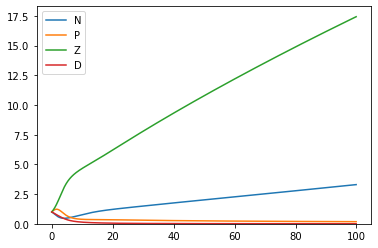

In [10]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

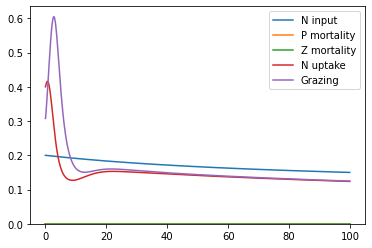

In [11]:
plt.plot(time, odeint_out.Input__input_value, label='N input')
plt.plot(time, odeint_out.Mortality__death_value, label='P mortality')
plt.plot(time, odeint_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, odeint_out.NutrientUptake__uptake_value, label='N uptake')
plt.plot(time, odeint_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()

In [12]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [13]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
Initializing component Input
Initializing component Mortality
Initializing component QuadMortality
Initializing component NutrientUptake
Initializing component Grazing
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x1169ab580>
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['N0_value', 'Input_rate', 'Mortality_rate', 'QuadMortality_rate', 'NutrientUptake_halfsat', 'Grazing_fp_1', 'Grazing_fp_2', 'Grazing_Imax', 'Grazing_kZ'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Mortality_death', 'QuadMortality_death', 'NutrientUptake_uptake', 'Grazing_r1_out', 'Grazing_r2_out', 'Grazing_grazing'] 

finalizing: cleanup
Model was solved in 0.857

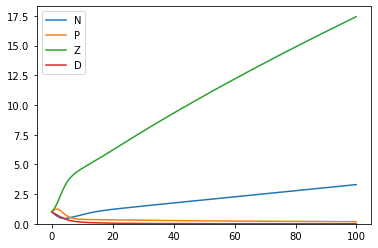

In [14]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

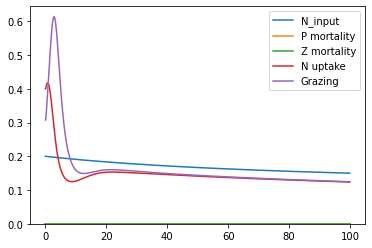

In [15]:
plt.plot(time, stepwise_out.Input__input_value, label='N_input')
plt.plot(time, stepwise_out.Mortality__death_value, label='P mortality')
plt.plot(time, stepwise_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, stepwise_out.NutrientUptake__uptake_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()

In [16]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [17]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
Initializing component Input
Initializing component Mortality
Initializing component QuadMortality
Initializing component NutrientUptake
Initializing component Grazing
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x116c524c0>
['$time=1', '$n=((0+((n0)*(input_rate)))+(-((((n)/((n+nutrientuptake_halfsat))))*(p))))', '$p=(((0+(-((p)*(mortality_rate))))+((((n)/((n+nutrientuptake_halfsat))))*(p)))+(-((((((((grazing_imax)*(((p)^(2)))))*(grazing_fp_1)))/((((grazing_kz)^(2))+((0+((((p)^(2)))*(grazing_fp_1)))+((((d)^(2)))*(grazing_fp_2)))))))*(z))))', '$z=((0+(-((((z)^(2)))*(quadmortality_rate))))+(((((((((grazing_imax)*(((p)^(2)))))*(grazing_fp_1)))/((((grazing_kz)^(2))+((0+((((p

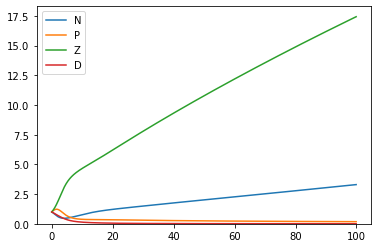

In [18]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

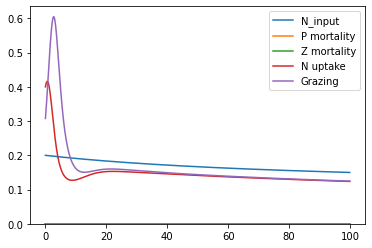

In [19]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.plot(time, gekko_out.Mortality__death_value, label='P mortality')
plt.plot(time, gekko_out.QuadMortality__death_value, label='Z mortality')
plt.plot(time, gekko_out.NutrientUptake__uptake_value, label='N uptake')
plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()